In [1]:
!pip install yahoofinancials
!pip install finnhub-python
!pip install catboost
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
from sklearn import metrics
from catboost  import CatBoostClassifier
import finnhub
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38620 sha256=f0c9ef15ee030d5e03662ac702a6695a5ea78b809f47a8d90bb71bafcb528227
  Stored in directory: /root/.cache/pip/wheels/c6/bc/18/da12b3c280d31beeac0c0f491c8f370da7c1473a56d7d4b5f3
Successfully built yahoofinancials
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [33]:
#from google.colab import drive
#drive.mount('/content/drive')
#from google.colab import drive
#drive.mount('/content/gdrive')

# This is a API key I had to generate from finnhub portal, access is free for these news
finnhub_client = finnhub.Client(api_key="cucdo4pr01qri16nkovgcucdo4pr01qri16nkp00")
pd.options.display.max_rows = 999

# https://www.nasdaq.com/market-activity/stocks/screener?exchange=NASDAQ&render=download
NASDAQ = '/content/gdrive/MyDrive/Colab Notebooks/nasdaq_screener_1738035733789.csv'

stock_data_lookup=pd.read_csv("{}".format(NASDAQ))
stock_data_lookup['Last Sale']=stock_data_lookup['Last Sale'].apply(lambda x: x.split('$')[1])
stock_data_lookup['Last Sale']=stock_data_lookup['Last Sale'].astype('float')
stock_data_lookup=stock_data_lookup[(stock_data_lookup['Last Sale']>20) ]
stock_data_lookup=stock_data_lookup[stock_data_lookup['Volume']>500000]

df_columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume','related']
df_sentiment_columns = ['related','source','summary','category','datetime']

df_stock=pd.DataFrame(columns=df_columns)
df_sentiment=pd.DataFrame(columns=df_sentiment_columns)

for n,i in  enumerate(stock_data_lookup['Symbol'].sample(n=120).to_list()):
    try:
        # get the stock pricing data from yahoo finance API
        tmp_df = yf.download("{}".format(i), period='1y')
        tmp_df.columns = tmp_df.columns.get_level_values(0)
        tmp_df=tmp_df.reset_index()
        tmp_df['related']=i
        tmp_df.columns= df_columns
        df_stock=pd.concat([tmp_df,df_stock])
        print (n, ' out of {}'.format(df_stock.shape[0]), i)

        # get the stock sentiment data from finnhub API (API key is above, this is my personal key that I created on their website)
        data=finnhub_client.company_news("{}".format(i),
                                         _from= (pd.to_datetime('today')+ pd.DateOffset(years=-1)).strftime('%Y-%m-%d'),
                                         to=pd.to_datetime('today').strftime('%Y-%m-%d'))
        if data:
             tmp_df=pd.DataFrame(data)[df_sentiment_columns]
             df_sentiment=pd.concat([tmp_df,df_sentiment])
    except:
        print ("Stock ({}) data wasn't retrieved".format(i))
        pass  # no need to throw an error

print (df_sentiment.shape,df_stock.shape )
df_sentiment['dt_time'] = pd.to_datetime(df_sentiment.datetime, unit='s')
df_sentiment['dt_date']= pd.to_datetime(df_sentiment.dt_time.dt.date)
df_stock['dt_date'] = pd.to_datetime(df_stock['Date'])

# Left joining stock price and stock sentiment data in stock name and data
# Removing news after market is closed to make sure we respect causality.
df_sentiment[df_sentiment.dt_time.dt.time<pd.to_datetime('16:00:00').time()]
df = pd.merge(df_stock,df_sentiment, on = ['related','dt_date' ], how='left')




[*********************100%***********************]  1 of 1 completed
<ipython-input-33-ea3cb2ed05ef>:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_stock=pd.concat([tmp_df,df_stock])


0  out of 251 EXEL


[*********************100%***********************]  1 of 1 completed


1  out of 502 INCY


[*********************100%***********************]  1 of 1 completed


2  out of 753 PCVX


[*********************100%***********************]  1 of 1 completed


3  out of 1004 RNA


[*********************100%***********************]  1 of 1 completed


4  out of 1255 VRRM


[*********************100%***********************]  1 of 1 completed


5  out of 1506 LITE


[*********************100%***********************]  1 of 1 completed


6  out of 1757 SBAC


[*********************100%***********************]  1 of 1 completed


7  out of 2008 FFIV


[*********************100%***********************]  1 of 1 completed


8  out of 2259 NWE


[*********************100%***********************]  1 of 1 completed


9  out of 2510 FIVN


[*********************100%***********************]  1 of 1 completed


10  out of 2761 CART


[*********************100%***********************]  1 of 1 completed


11  out of 3012 CALM


[*********************100%***********************]  1 of 1 completed


12  out of 3263 OLLI


[*********************100%***********************]  1 of 1 completed


13  out of 3514 GDS


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


14  out of 3765 CGON
15  out of 4016 PZZA


[*********************100%***********************]  1 of 1 completed


16  out of 4267 TECH


[*********************100%***********************]  1 of 1 completed


17  out of 4518 ACVA


[*********************100%***********************]  1 of 1 completed


18  out of 4769 LEGN


[*********************100%***********************]  1 of 1 completed


19  out of 5020 TTEK


[*********************100%***********************]  1 of 1 completed


20  out of 5271 PPC


[*********************100%***********************]  1 of 1 completed


21  out of 5522 CSGP


[*********************100%***********************]  1 of 1 completed


22  out of 5773 VRSN


[*********************100%***********************]  1 of 1 completed


23  out of 6024 HRMY


[*********************100%***********************]  1 of 1 completed


24  out of 6275 PPBI


[*********************100%***********************]  1 of 1 completed


25  out of 6526 PSIX


[*********************100%***********************]  1 of 1 completed


26  out of 6777 ACHC


[*********************100%***********************]  1 of 1 completed


27  out of 7028 QNST


[*********************100%***********************]  1 of 1 completed


28  out of 7279 AGYS


[*********************100%***********************]  1 of 1 completed


29  out of 7530 SBUX


[*********************100%***********************]  1 of 1 completed


30  out of 7781 CEG


[*********************100%***********************]  1 of 1 completed


31  out of 8032 DDOG


[*********************100%***********************]  1 of 1 completed


32  out of 8283 SSNC


[*********************100%***********************]  1 of 1 completed


33  out of 8534 INSM


[*********************100%***********************]  1 of 1 completed


34  out of 8785 NAMS


[*********************100%***********************]  1 of 1 completed


35  out of 9036 TXN


[*********************100%***********************]  1 of 1 completed


36  out of 9287 PRCT


[*********************100%***********************]  1 of 1 completed


37  out of 9538 PANW


[*********************100%***********************]  1 of 1 completed


38  out of 9789 EXE


[*********************100%***********************]  1 of 1 completed


39  out of 10040 WGS


[*********************100%***********************]  1 of 1 completed


40  out of 10291 LNT


[*********************100%***********************]  1 of 1 completed


41  out of 10542 NVCR


[*********************100%***********************]  1 of 1 completed


42  out of 10793 MDB


[*********************100%***********************]  1 of 1 completed


43  out of 11044 AFRM


[*********************100%***********************]  1 of 1 completed


44  out of 11295 PRGS


[*********************100%***********************]  1 of 1 completed


45  out of 11546 PECO


[*********************100%***********************]  1 of 1 completed


46  out of 11797 BLBD


[*********************100%***********************]  1 of 1 completed


47  out of 12048 TER


[*********************100%***********************]  1 of 1 completed


48  out of 12299 COO


[*********************100%***********************]  1 of 1 completed


49  out of 12550 NTAP


[*********************100%***********************]  1 of 1 completed


50  out of 12801 LKQ


[*********************100%***********************]  1 of 1 completed


51  out of 13052 RYAAY


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


52  out of 13303 HALO
53  out of 13554 SCVL


[*********************100%***********************]  1 of 1 completed


54  out of 13805 TWST


[*********************100%***********************]  1 of 1 completed


55  out of 14056 QDEL


[*********************100%***********************]  1 of 1 completed


56  out of 14307 MIDD


[*********************100%***********************]  1 of 1 completed


57  out of 14558 CPRX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


58  out of 14809 TCOM
59  out of 15060 SMCI


[*********************100%***********************]  1 of 1 completed


60  out of 15311 PLAB
Stock (PLAB) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


61  out of 15562 MNRO
Stock (MNRO) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


62  out of 15813 COHU
Stock (COHU) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


63  out of 16064 TLN
Stock (TLN) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


64  out of 16315 LOGI
Stock (LOGI) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


65  out of 16566 CLDX
Stock (CLDX) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


66  out of 16817 GNTX
Stock (GNTX) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


67  out of 17068 CHRW
Stock (CHRW) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


68  out of 17319 PRVA
Stock (PRVA) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


69  out of 17570 NTES
Stock (NTES) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


70  out of 17821 PFG
Stock (PFG) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


71  out of 18072 NTNX
Stock (NTNX) data wasn't retrieved
72  out of 18323 VKTX
Stock (VKTX) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


73  out of 18574 AVT
Stock (AVT) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


74  out of 18702 LINE
Stock (LINE) data wasn't retrieved
75  out of 18953 MAR


[*********************100%***********************]  1 of 1 completed


Stock (MAR) data wasn't retrieved
76  out of 19204 MU
Stock (MU) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


77  out of 19455 LRCX
Stock (LRCX) data wasn't retrieved
78  out of 19706 KNSA
Stock (KNSA) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


79  out of 19957 NICE
Stock (NICE) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


80  out of 20208 STRL
Stock (STRL) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


81  out of 20459 MLKN
Stock (MLKN) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


82  out of 20710 GFS
Stock (GFS) data wasn't retrieved
83  out of 20961 ENPH
Stock (ENPH) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


84  out of 21212 HOLX
Stock (HOLX) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


85  out of 21463 CGNX
Stock (CGNX) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


86  out of 21714 REG
Stock (REG) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


87  out of 21965 ONB
Stock (ONB) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


88  out of 22216 COOP
Stock (COOP) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


89  out of 22467 PDD
Stock (PDD) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


90  out of 22718 EXC
Stock (EXC) data wasn't retrieved
91  out of 22969 APLS


[*********************100%***********************]  1 of 1 completed

Stock (APLS) data wasn't retrieved
92  out of 23220 GEHC



[*********************100%***********************]  1 of 1 completed

Stock (GEHC) data wasn't retrieved



[*********************100%***********************]  1 of 1 completed


93  out of 23471 PENN
Stock (PENN) data wasn't retrieved
94  out of 23722 VERX
Stock (VERX) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


95  out of 23973 IAC
Stock (IAC) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


96  out of 24224 IONS
Stock (IONS) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


97  out of 24475 UMBF
Stock (UMBF) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


98  out of 24726 SIMO
Stock (SIMO) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


99  out of 24977 VRSK
Stock (VRSK) data wasn't retrieved
100  out of 25228 LUNR


[*********************100%***********************]  1 of 1 completed

Stock (LUNR) data wasn't retrieved
101  out of 25479 PCAR
Stock (PCAR) data wasn't retrieved



[*********************100%***********************]  1 of 1 completed


102  out of 25730 HOOD
Stock (HOOD) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


103  out of 25981 IRDM
Stock (IRDM) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

104  out of 26232 CTSH
Stock (CTSH) data wasn't retrieved


105  out of 26483 ATSG
Stock (ATSG) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


106  out of 26734 GLPI
Stock (GLPI) data wasn't retrieved
107  out of 26985 BSY
Stock (BSY) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


108  out of 27236 CVBF
Stock (CVBF) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


109  out of 27487 NDAQ
Stock (NDAQ) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


110  out of 27738 OZK
Stock (OZK) data wasn't retrieved
111  out of 27989 SATS
Stock (SATS) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


112  out of 28240 TMUS
Stock (TMUS) data wasn't retrieved
113  out of 28491 COCO
Stock (COCO) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


114  out of 28742 MPWR
Stock (MPWR) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


115  out of 28993 HSIC
Stock (HSIC) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


116  out of 29244 VRNS
Stock (VRNS) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed


117  out of 29495 NARI
Stock (NARI) data wasn't retrieved


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


118  out of 29746 PEP
Stock (PEP) data wasn't retrieved
119  out of 29997 AMSC
Stock (AMSC) data wasn't retrieved
(11262, 5) (29997, 7)


In [7]:
# Extract sentiment score from the transformer pipeline, in this code I am using the default LLM model: https://huggingface.co/blog/sentiment-analysis-python
# The LLM model detect if the news is positve or negative. This approach can be improived further by fine tunning the model on these type of financial data and/or incorporate better baseline models.
def get_sentiment_scores(row):
  if isinstance(row, str):
      return sentiment_pipeline(row[:512])[0]['score']
  else:
    return np.nan

# get unique news to avoide duplicates
df_sentiment_lookup=df.summary.dropna().drop_duplicates().to_frame()
print ("Number of unique news {}".format(df_sentiment_lookup.shape[0]))
df_sentiment_lookup['scores']=df_sentiment_lookup.summary.apply(get_sentiment_scores)

# Join the lookup table with scores back to the final data
df_final = pd.merge(df,df_sentiment_lookup,on=['summary'],how='left')
df_final.drop_duplicates(subset = ['related','dt_date'],inplace=True)

# Define two boolean features which indicate if a news is pre- or during-market.
df_final['pre_market_news'] = np.where(df_final.dt_time.dt.time<pd.to_datetime('09:30:00').time(), 1, 0)
df_final['during_market_news'] = np.where(df_final.dt_time.dt.time>pd.to_datetime('09:30:00').time(), 1, 0)




Number of unique news 5984


In [8]:
# Define some feature based on the price: High/Open, Close/Open, moving averages based on the 10 and 20 days, and SMA ratios to the opening of a given day.

df_final['high_o_open']= df_final['High']/df_final['Open']
df_final['close_o_open']= df_final['Close']/df_final['Open']
df_final['sma_10'] = df_final.groupby('related')['Close'].transform(lambda x: x.rolling(10, 3).mean())
df_final['sma_20'] = df_final.groupby('related')['Close'].transform(lambda x: x.rolling(20, 3).mean())
df_final['sma_10_o_open'] = df_final['sma_10']/df_final['Open'] # to make sure that the model isn't dependeant on the magnitude of the price
df_final['sma_20_o_open'] = df_final['sma_20']/df_final['Open'] # to make sure that the model isn't dependeant on the magnitude of the price

# Define label for the classification model: assumption is that if a signficant news comes up it affects the market short term (assuming for a positive news prices should go up), maybe in the same day or perhaps the next.
# This is a bold assumption, but for the sake of getting baseline results, I assume this is ok. For the price change I also assume that day closing is 5% higher than the closing.
#df_final['label_1']=np.where(df_final.high_o_open>1.05,1,0)
df_final['label']=np.where(df_final.close_o_open>1.05,1,0)

In [18]:
# create out of time validation sets: build the model, and test the model. We keep last three months of data as a test set.
df_final_train = df_final[df_final.dt_date<pd.to_datetime('today')+pd.DateOffset(months=-3)]
df_final_test  = df_final[df_final.dt_date>=pd.to_datetime('today')+pd.DateOffset(months=-3)]

In [19]:
# Train a Catboost model: https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier
cb_model = CatBoostClassifier(iterations=600,
                       learning_rate=0.01,
                              depth=10)

# We explicitely pass the categorical features to the model, and it does target encoding under the hood, this is how Catboost is known for.
# These two categoricalfeatures are: news source and news category.
CAT_COLUMNS = ['source','category']
COLUMNS=['pre_market_news', 'during_market_news', 'sma_10_o_open', 'sma_20_o_open', 'scores', 'source', 'category', 'label']
df_final_train=df_final_train[COLUMNS]
cat_features = [df_final_train.columns.get_loc(x) for x in CAT_COLUMNS]

for i in CAT_COLUMNS:
    df_final_train[i]=df_final_train[i].fillna('MISSING')
    df_final_test[i]=df_final_test[i].fillna('MISSING')


df_final_train['label']=df_final_train['label'].astype('int')
cb_model.fit(df_final_train.drop(['label'],axis=1),
             df_final_train['label'],
             cat_features=cat_features,
             verbose=True)

<ipython-input-19-e1dd5571c3e2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_train[i]=df_final_train[i].fillna('MISSING')
<ipython-input-19-e1dd5571c3e2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_test[i]=df_final_test[i].fillna('MISSING')
<ipython-input-19-e1dd5571c3e2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

0:	learn: 0.6753895	total: 25ms	remaining: 15s
1:	learn: 0.6574400	total: 62.1ms	remaining: 18.6s
2:	learn: 0.6410000	total: 83.5ms	remaining: 16.6s
3:	learn: 0.6243584	total: 115ms	remaining: 17.1s
4:	learn: 0.6085975	total: 134ms	remaining: 15.9s
5:	learn: 0.5937721	total: 148ms	remaining: 14.7s
6:	learn: 0.5781648	total: 205ms	remaining: 17.4s
7:	learn: 0.5631426	total: 261ms	remaining: 19.3s
8:	learn: 0.5486619	total: 325ms	remaining: 21.4s
9:	learn: 0.5348718	total: 390ms	remaining: 23s
10:	learn: 0.5211839	total: 459ms	remaining: 24.6s
11:	learn: 0.5079207	total: 524ms	remaining: 25.7s
12:	learn: 0.4955480	total: 590ms	remaining: 26.7s
13:	learn: 0.4837294	total: 609ms	remaining: 25.5s
14:	learn: 0.4726881	total: 622ms	remaining: 24.2s
15:	learn: 0.4616148	total: 669ms	remaining: 24.4s
16:	learn: 0.4511627	total: 685ms	remaining: 23.5s
17:	learn: 0.4401069	total: 765ms	remaining: 24.7s
18:	learn: 0.4298836	total: 833ms	remaining: 25.5s
19:	learn: 0.4197091	total: 895ms	remaining:

Threshold value is: 0.025813229623282988
train/test AUCs: 0.782/0.719


<ipython-input-21-d70a0bb2a736>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_test[i]=df_final_test[i].fillna('MISSING')
<ipython-input-21-d70a0bb2a736>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_test['prediction']=y_pred[:,1]
<ipython-input-21-d70a0bb2a736>:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Train/Test AUCs: {}/{}'.format

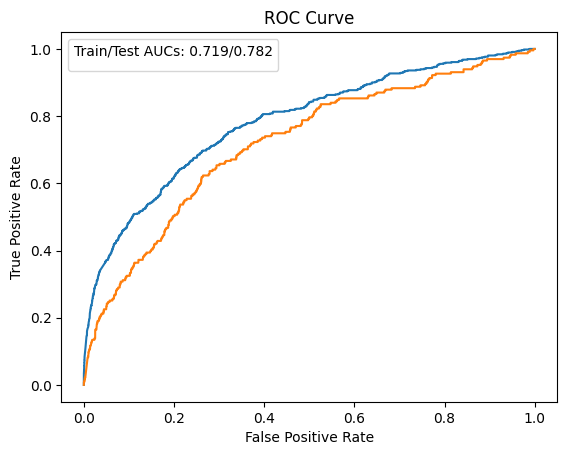

In [21]:
import matplotlib.pyplot as plt
y_pred=cb_model.predict_proba(df_final_train.drop(['label'],axis=1))
df_final_train['prediction']=y_pred[:,1]



fpr, tpr, thresholds = metrics.roc_curve(df_final_train.label,df_final_train.prediction)
auc_train=metrics.auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.legend(title='Training set AUC: {}'.format(round(auc_train,2)))


COLUMNS=['pre_market_news', 'during_market_news','sma_10_o_open', 'sma_20_o_open', 'scores', 'source', 'category', 'label']
for i in CAT_COLUMNS:
    df_final_test[i]=df_final_test[i].fillna('MISSING')

y_pred=cb_model.predict_proba(df_final_test[COLUMNS].drop(['label'],axis=1))
df_final_test['prediction']=y_pred[:,1]

fpr, tpr, thresholds = metrics.roc_curve(df_final_test.label,df_final_test.prediction)
auc_test=metrics.auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(title='Train/Test AUCs: {}/{}'.format(round(auc_test,3),round(auc_train,3)))

print("train/test AUCs: {}/{}".format(round(auc_train,3),round(auc_test,3)))




In [22]:
# Feature importances
print (cb_model.get_feature_importance(prettified=True))

           Feature Id  Importances
0       sma_10_o_open    41.541964
1       sma_20_o_open    37.050563
2              scores     9.518881
3              source     3.936881
4  during_market_news     3.437442
5     pre_market_news     2.440789
6            category     2.073481


In [24]:
# NTILE the test data into 1% level, based on the probability from high to low
df_final_test['ntile']=pd.qcut(df_final_test.prediction, 100, labels=['bin{}'.format(i) for i in range(100)])

<ipython-input-24-74397ec5fb53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_test['ntile']=pd.qcut(df_final_test.prediction, 100, labels=['bin{}'.format(i) for i in range(100)])


In [30]:
df_final_test.groupby(['ntile','label'])['prediction'].agg(['count']).unstack().reset_index()

<ipython-input-30-debd73aae3b8>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_test.groupby(['ntile','label'])['prediction'].agg(['count']).unstack().reset_index()


ntile count    
label            0   1
0       bin0    71   1
1       bin1    70   2
2       bin2    72   0
3       bin3    72   0
4       bin4    71   1
5       bin5    70   2
6       bin6    71   1
7       bin7    72   0
8       bin8    72   0
9       bin9    72   0
10     bin10    71   1
11     bin11    69   3
12     bin12    71   1
13     bin13    70   2
14     bin14    72   0
15     bin15    70   2
16     bin16    72   0
17     bin17    72   0
18     bin18    71   1
19     bin19    72   0
20     bin20    72   0
21     bin21    71   1
22     bin22    69   3
23     bin23    69   4
24     bin24    70   1
25     bin25    72   0
26     bin26    71   1
27     bin27    72   0
28     bin28    72   0
29     bin29    72   0
30     bin30    72   0
31     bin31    71   1
32     bin32    70   2
33     bin33    72   0
34     bin34    70   2
35     bin35    72   0
36     bin36    70   2
37     bin37    72   0
38     bin38    72   0
39     bin39    72   0
40     bin40    72   0
41     bin41    72   0
42     bin42    70   2
43     bin43    72   1
44     bin44    70   1
45     bin45    72   0
46     bin46    69   3
47     bin47    69   3
48     bin48    69   3
49     bin49    70   2
50     bin50    68   4
51     bin51    72   0
52     bin52    71   1
53     bin53    69   3
54     bin54    71   1
55     bin55    72   0
56     bin56    72   0
57     bin57    70   2
58     bin58    71   1
59     bin59    70   2
60     bin60    71   1
61     bin61    71   2
62     bin62    68   3
63     bin63    70   2
64     bin64    71   2
65     bin65    68   3
66     bin66    71   1
67     bin67    70   2
68     bin68    72   1
69     bin69    68   3
70     bin70    70   3
71     bin71    70   1
72     bin72    66   6
73     bin73    67   5
74     bin74    69   3
75     bin75    70   2
76     bin76    68   4
77     bin77    68   5
78     bin78    70   3
79     bin79    67   3
80     bin80    66   6
81     bin81    66   7
82     bin82    69   2
83     bin83    67   5
84     bin84    71   2
85     bin85    68   3
86     bin86    70   2
87     bin87    70   2
88     bin88    65   7
89     bin89    69   3
90     bin90    70   3
91     bin91    65   6
92     bin92    66   6
93     bin93    70   2
94     bin94    66   6
95     bin95    67   5
96     bin96    64   8
97     bin97    63   9
98     bin98    77  18
99     bin99    38  11

In [31]:
# optimal_threshold is obtained from the ROC curve, where we maximize tpr and minimize fpr. Anything above this threshold we consider positive label
df_final_test[df_final_test.prediction > optimal_threshold].label.value_counts()

,count
label,
0,2215
1,154


In [32]:
# optimal_threshold is obtained from the ROC curve, where we maximize tpr and minimize fpr. Anything below this threshold we consider negative label

df_final_test[df_final_test.prediction <= optimal_threshold].label.value_counts()

,count
label,
0,4754
1,77


## Summary

Model development:


*   Obtain the stock price data from yahoo finance API and news data from finnhub API. They are FREE APIs for this use case, at least.     
*   Extract features from news based on the LLM model. We fed the news to LLM (used default bert model under transformer) which was categorizing a news being positive with a given probability. We added additional news features, like category, source, and news time being pre-market or during market.     
*   We included additional features based on daily price moving average (10 and 20 days). From reading online, these seems to be a common way of incorporating prices.
*   We used NASDAQ listing to select a set of stocks with a price above 20$, and traded volume > 500K. There are lots of stocks with low prices that fluctuate under different circumstances, thus without doing a bit more deep dive, I excluded them. I randomly picked 120 stocks for this assignment.  
*   Labels are defined as the price difference between close and open of a given day. The assumption here is that news mostly have a short term effect on stock volatility. This can be further refined based on various assumptions, but this is the assumption used in the analysis. Basically, we predict given the daily Open price and news in a given day (premarket or during market), can we predict if Close price will be higher (>5%) than the Open. This can be fine-tuned based on different assumptions and conditions.     
*   Catboost model used with a handful of features from news and price, as mentioned above.  
*   Model trained on the data between 2024-01-28 and 2024-10-28
*   Model tested on the data between 2024-10-29 and 2025-01-28

Model evaluation:


*   I used ROC metric to evaluate the model's performance
*   I optimized probability from ROC by miximing true positive rate and minimize false positive rate. This turned out to be 0.258
*   I provided two representations for model's performance: 1. ntile the test data into 1% level based on probability (from high to low), and check which bin captures most of the positive labels. Typically higher probability bins should have higher capture rates, which is seen from the above table.
*   I also classified all data points as positives with probability higher than the threshold (see above). This selects best stocks subset, which has  4.3X higher capture rate for positive labels (stocks with Close price being higher by 5% than Open).   

Model improvement:


Ares for further improvement:

*   Settle of volatile definitions. This is critical to align as to what we call volatility, and how to quantify.
*   Sentiment analysis via LLM can be improved by fine tunning the best model on the data we typically see under these news. So the model has more accurate understanding
*   Incorporate some key words that are important for Stocks, this requires some domain knowledge, and also the problem we are trying to solve.
*   Include more data sources capturing different aspects of the stock market.  
*   Tune the catboost model with better parameter subsets by performing cross-validation.





















